In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split as tts 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from scipy.sparse import coo_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
df = pd.read_excel("./Data1.xlsx")

In [4]:
df = df.drop(['Unnamed: 0'],1)

In [5]:
df = df.drop_duplicates(subset=['OpportunityId','OpportunityStageName', 'ActivityDescription']).reset_index(drop=True)

In [6]:
df.OpportunityStageName.value_counts()

Closed Dead           74138
Closed Won            35313
Prospecting           15264
Proposal              10234
Closed Lost            4683
Closed Happy Free       736
Evaluating              431
Demonstration           418
Negotiating             211
Reversal                162
Lead Qualification       21
Need  Analysis           19
Overdue                   5
Name: OpportunityStageName, dtype: int64

# Lets have a look at the number of examples for every individual class

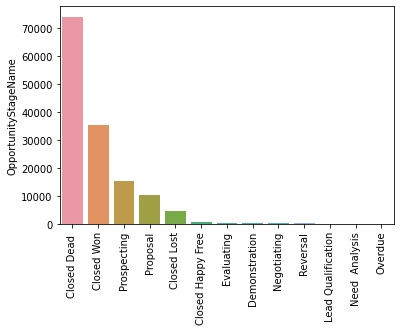

In [7]:
sns.barplot(x=df.OpportunityStageName.value_counts().index, y=df.OpportunityStageName.value_counts())
plt.xticks(rotation=90)
plt.show()

In [8]:
df['label'] = df['OpportunityStageName'].apply(lambda x: 'Won' if x == "Closed Won" else 'Loss')

In [9]:
df.label.value_counts()

Loss    106322
Won      35313
Name: label, dtype: int64

In [10]:
print(f"Dataframe Dimensions are {df.shape}")

Dataframe Dimensions are (141635, 4)


In [11]:
df.head()

,OpportunityId,OpportunityStageName,ActivityDescription,label
0,0006255A-A476-4DEF-9C67-0E4B0A83ACD0,Closed Won,"#ProformaInvoice\r\nDear Sir,\r\n\r\nThanks fo...",Won
1,0006255A-A476-4DEF-9C67-0E4B0A83ACD0,Closed Won,"#Emailed\r\nDear Sir,\r\n\r\nPlease find revis...",Won
2,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ...",Loss
3,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,#Follow up\r\n\r\nCalled on landline number\r\...,Loss
4,00099CB6-D6A0-460E-85C1-96013DE68CA9,Closed Dead,"#DemoArranged\r\n\r\nSpoke with Rakesh, said h...",Loss


In [12]:
num = np.random.randint(0,df.shape[0])
for i in range(num,num+3):
    print(i, "--",df['label'][i])
    print(df["ActivityDescription"][i])
    print('\n----------------------\n')

68902 -- Loss
#EmailSent

Dear Balram,

With reference to below mail, we are trying to reach you but couldn't get through.

Please update on below quote on priority basis, your FieldSense contract has been expired on 31st July.

Regards

Pratima Shahi

----------------------

68903 -- Loss
#Followup

Had a word with Mr. Balram, said he has sent remider mail twice to finance team but not getting any revert
Told him alreadt 17 days has paased & we had given payment term & contract extension for last month
Said he cann't force finance team...asked him to help with Finance team contact detail said dont contact them they will clearly say no to your proposal..asked him to update by tomorrow otherwise will deactivate the panel

----------------------

68904 -- Loss
#EmailSent

Dear Balram,

With reference to our discussion, we already have extended given offer till now & further extension wouldn't be feasible to us.

Request you to confirm for given offer & release payment to continue with Fi

# It looks like we have sentences of all different kind of lengths.. lets see their distribution

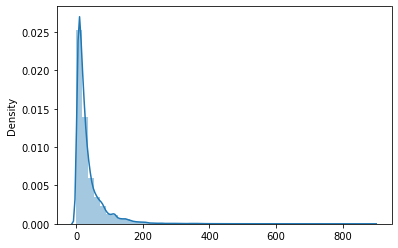

In [13]:
df['tokens'] = df.apply(lambda x: word_tokenize(str(x['ActivityDescription'])), axis=1)
lengths = [len(line) for line in df["tokens"]]
sns.distplot(lengths)
plt.show()

# Most of the sentences are having length between the range of 0-200. We have few outliers where no.of words in a sentence can be beyond 200. 
# We can have a look at an example

In [14]:
print(df["ActivityDescription"][np.argmax(lengths)])

Hi Jerrian,

Please find the below email which is received from our legal team.

Regards,

Jyotsana.


-------- Forwarded Message --------
Subject: 	Re: Fwd: RE: Service Provider Agreement document updates - Bajaj Finanace, Pune
Date: 	Wed, 29 Jan 2020 18:04:34 +0530
From: 	QLC MailServe Team <mailserve@qlc.in>
To: 	QLC Sales - Pune <sales.west@qlc.in>


Hi Jyotsana,

Respond back as below:

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    QLC: Taxation structure may change from time to time over above the tax rates. Hence it should not be inclusive of taxes.

    "

    BFL: Can we change the sentence to Fee + Applicable Taxes??

    ----------------------------------------------------------------------------------------------------------------

# It is quite clear that we have to deal with unnecessary texts, spaces and a lot of punctuations 

In [15]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
stop = stopwords.words('english')

df['ActivityDescription'] = df.apply(lambda x : decontracted(str(x['ActivityDescription'])),axis=1)
df['preprocessed_text'] = df['ActivityDescription']
# .replace('\n',' ').replace('\t', '')
df['preprocessed_text'] = df.apply(lambda x : re.sub('.^Sent.*\n?|.^To.*\n?|.^From.*\n?|.^Date.*\n?|.^F.*\n?|.*Regards.*\n?|.^Subject.*\n?|www.\S+|\S*@\S*\s?', '', str(x['ActivityDescription'])).lower(), axis=1)
df['preprocessed_text'] = df.apply(lambda x : re.sub('[^A-Za-z0-9\']+', ' ', str(x['preprocessed_text'])).lower(), axis=1)
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join(word for word in x.split() if not (word.isalpha() and len(word) < 3)))

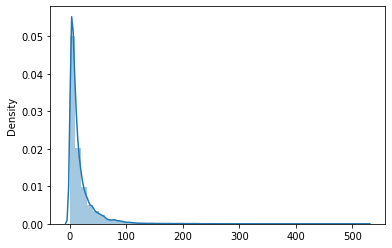

In [17]:
df['newtokens'] = df.apply(lambda x: word_tokenize(x['preprocessed_text']), axis=1)
newlengths = [len(line) for line in df["newtokens"]]
sns.distplot(newlengths)
plt.show()

# Great!! The maximum length reducing to around 500 because of preprocessing. Looks fine. Now lets compare few raw strings and preprocessed strings to see whether we capture all the relevant information and also lets take care of zero length rows

In [18]:
numb = np.random.randint(0,df.shape[0])
print(df["ActivityDescription"][numb],"\n","---------------","\n",df["preprocessed_text"][numb])

#Followup

Drop msg to Mr Ronak for the FS Update and further action  
 --------------- 
 followup drop msg ronak update action


# Let's check for empty text after preprocessing and get rid of it, if it is not making any useful contribution

In [19]:
count = [x for x in range(df.shape[0]) if len(df["preprocessed_text"][x])==0]
len(count)

21

In [20]:
def print_unwanted(l):
  for item in l:
    print(df['ActivityDescription'][item],"\n","---------------","\n",df['preprocessed_text'][item])
    print("\n","++++++++++++++++++++","\n")

In [21]:
print_unwanted(count[:10])

-  
 --------------- 
 

 ++++++++++++++++++++ 

WO 
 --------------- 
 

 ++++++++++++++++++++ 

#WO

WO-FS 
 --------------- 
 

 ++++++++++++++++++++ 

-  
 --------------- 
 

 ++++++++++++++++++++ 

#c 
 --------------- 
 

 ++++++++++++++++++++ 

#WO

WO - FS 
 --------------- 
 

 ++++++++++++++++++++ 

#WO

WO - FS 
 --------------- 
 

 ++++++++++++++++++++ 


 
 
 --------------- 
 

 ++++++++++++++++++++ 

WO - MS 
 --------------- 
 

 ++++++++++++++++++++ 

#WO

WO - MS 
 --------------- 
 

 ++++++++++++++++++++ 



# Cool. Now let's see what are the most occuring words

In [22]:
df = df.drop(df.index[count])

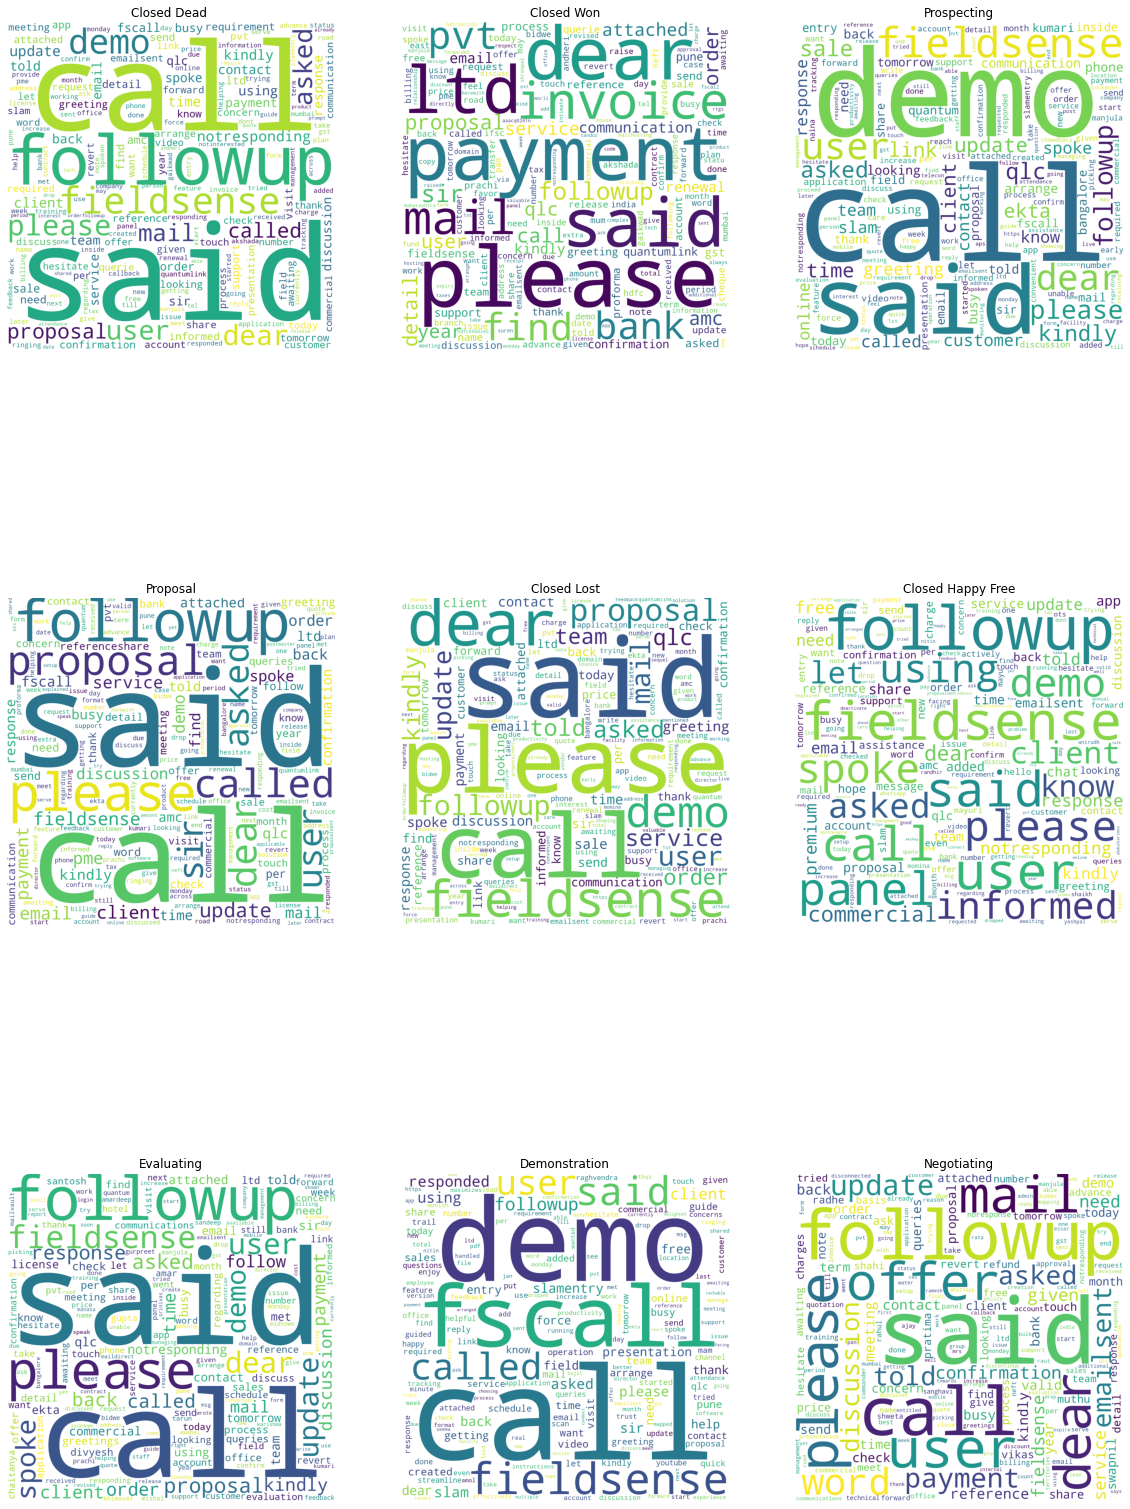

In [ ]:
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['OpportunityStageName']==r]['preprocessed_text'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
rest=df['OpportunityStageName'].value_counts()[:9].index        
produce_wordcloud(rest)

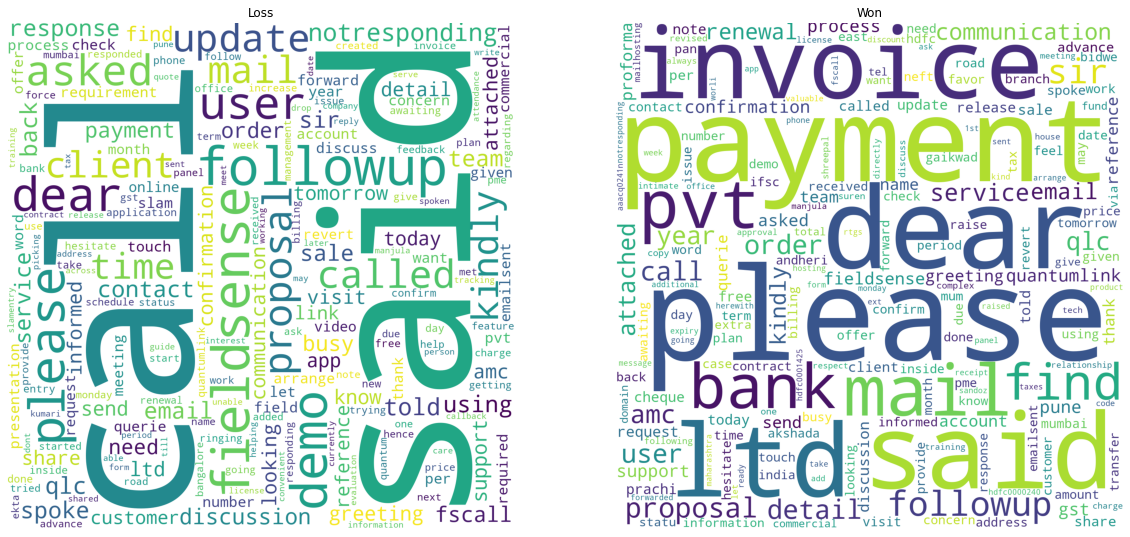

In [23]:
def produce_cloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(1,2,i+1)
        corpus=df[df['label']==r]['preprocessed_text'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
rest_=df['label'].value_counts().index        
produce_cloud(rest_)

# We can see above there are a few words occuring in both the classes. They make no sense. So let's get rid of them

In [26]:
stop.extend(['said','please','ltd','pvt','regard','dear','sir','qlc'])
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

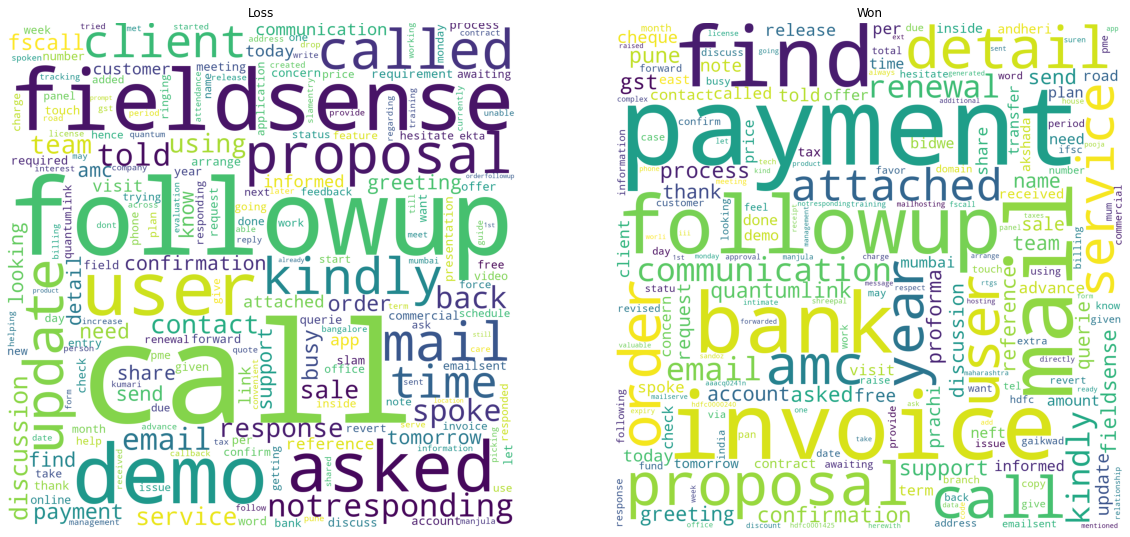

In [28]:
new = df['label'].value_counts().index        
produce_cloud(new)

# Looks fine now. Let's proceed to feature engineering

In [29]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 9.7MB/s 


In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()
df['sentiments'] = df.apply(lambda x : sid_obj.polarity_scores(x['preprocessed_text']),axis=1)

In [31]:
scores = df.apply(lambda x : sid_obj.polarity_scores(x['preprocessed_text']),axis=1)

In [33]:
df["sentiments"] = df["sentiments"].apply(lambda x : dict(eval(str(x))) )
new_df = df["sentiments"].apply(pd.Series)

In [34]:
df = pd.concat([df, new_df], axis=1)

In [35]:
df['sent_length'] = df.apply(lambda x : len(str(x['preprocessed_text'])),axis=1)
df['char_length'] = df.apply(lambda x : len(''.join(set(str(x['preprocessed_text']).replace(' ','')))),axis=1)
df['word_length'] = df.apply(lambda x : len(str(x['preprocessed_text']).split()),axis=1)
df['num_unique_words'] = df.apply(lambda x: len(set(w for w in str(x['preprocessed_text']).split())),axis=1)
df['words_vs_unique'] = df['num_unique_words'] / df['word_length']

In [36]:
df = df.drop(['sentiments','tokens','OpportunityId','OpportunityStageName'],1)

In [37]:
df.head()

,ActivityDescription,label,preprocessed_text,newtokens,neg,neu,pos,compound,sent_length,char_length,word_length,num_unique_words,words_vs_unique
0,"#ProformaInvoice\r\nDear Sir,\r\n\r\nThanks fo...",Won,proformainvoice thanks order confirmation find...,"[proformainvoice, dear, sir, thanks, order, co...",0.000,0.833,0.167,0.7351,235,25,33,32,0.969697
1,"#Emailed\r\nDear Sir,\r\n\r\nPlease find revis...",Won,emailed find revised proforma invoice kindly m...,"[emailed, dear, sir, please, find, revised, pr...",0.000,0.802,0.198,0.4939,97,21,14,14,1.000000
2,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ...",Loss,proposal ma'am greetings reference discussion ...,"[proposal, dear, ma'am, greetings, reference, ...",0.061,0.720,0.219,0.6705,221,22,29,25,0.862069
3,#Follow up\r\n\r\nCalled on landline number\r\...,Loss,follow called landline number discussed regari...,"[follow, called, landline, number, discussed, ...",0.114,0.762,0.124,0.0258,75,20,10,10,1.000000
4,"#DemoArranged\r\n\r\nSpoke with Rakesh, said h...",Loss,demoarranged spoke rakesh wants take demo unde...,"[demoarranged, spoke, rakesh, said, wants, tak...",0.071,0.842,0.088,0.1280,166,25,27,25,0.925926


In [38]:
loss_words = ['notresponding', 'busy', 'refund', 'decide', 'back', 'concern', 'revert', 'demo', 'waiting', 'update', 'disconnected', 'surely', 'issues']
won_words = ['confirm','coordinate','setup','sent','assuring','invoice','payment']

In [39]:
import collections
def ngram(text,n,list_):
    ngrm = zip(*[text.split()[i:] for i in range(n)])
    freq = collections.Counter(ngrm)
    grams = freq.most_common(50)
    for i in range(len(grams)):
        for j in range(n):
            list_.append(grams[i][0][j])
    return list(set(list_))

In [40]:
text_won = ' '.join(df[df['label'] == 'Won']['preprocessed_text'])

In [41]:
text_loss = ' '.join(df[df['label'] == 'Loss']['preprocessed_text'])

In [42]:
loss_words = ngram(text_loss,2,loss_words)
won_words = ngram(text_won,2,won_words)

In [43]:
df["losscount"] = df.apply(lambda x: sum(str(x['preprocessed_text']).count(w) for w in loss_words),axis=1)
df["normword_losswords"] = df["losscount"]/df['word_length']

In [44]:
df["woncount"] = df.apply(lambda x: sum(str(x['preprocessed_text']).count(w) for w in won_words),axis=1)
df["normword_wonwords"] = df["woncount"]/df['word_length']

In [45]:
df.head()

,ActivityDescription,label,preprocessed_text,newtokens,neg,neu,pos,compound,sent_length,char_length,word_length,num_unique_words,words_vs_unique,losscount,normword_losswords,woncount,normword_wonwords
0,"#ProformaInvoice\r\nDear Sir,\r\n\r\nThanks fo...",Won,proformainvoice thanks order confirmation find...,"[proformainvoice, dear, sir, thanks, order, co...",0.000,0.833,0.167,0.7351,235,25,33,32,0.969697,9,0.272727,31,0.939394
1,"#Emailed\r\nDear Sir,\r\n\r\nPlease find revis...",Won,emailed find revised proforma invoice kindly m...,"[emailed, dear, sir, please, find, revised, pr...",0.000,0.802,0.198,0.4939,97,21,14,14,1.000000,5,0.357143,8,0.571429
2,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ...",Loss,proposal ma'am greetings reference discussion ...,"[proposal, dear, ma'am, greetings, reference, ...",0.061,0.720,0.219,0.6705,221,22,29,25,0.862069,15,0.517241,13,0.448276
3,#Follow up\r\n\r\nCalled on landline number\r\...,Loss,follow called landline number discussed regari...,"[follow, called, landline, number, discussed, ...",0.114,0.762,0.124,0.0258,75,20,10,10,1.000000,4,0.400000,0,0.000000
4,"#DemoArranged\r\n\r\nSpoke with Rakesh, said h...",Loss,demoarranged spoke rakesh wants take demo unde...,"[demoarranged, spoke, rakesh, said, wants, tak...",0.071,0.842,0.088,0.1280,166,25,27,25,0.925926,6,0.222222,1,0.037037


In [46]:
def plot_dist(col=None):
    sns.distplot(df[df["label"] == 'Won'][col][0:], label = "1", color = 'red')
    sns.distplot(df[df["label"] == 'Loss'][col][0:], label = "0", color = 'blue')
    plt.show()

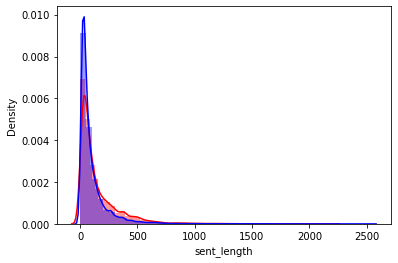

In [47]:
plot_dist('sent_length')

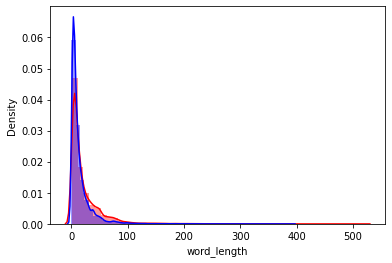

In [48]:
plot_dist('word_length')

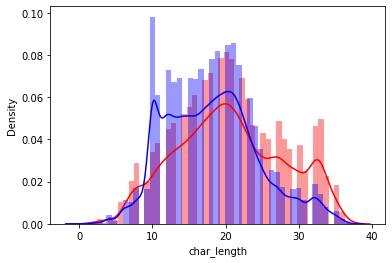

In [49]:
plot_dist('char_length')

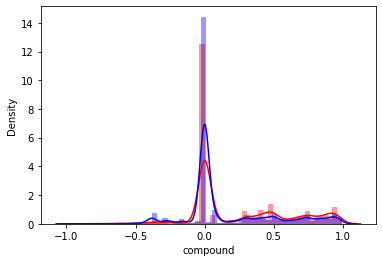

In [50]:
plot_dist('compound')

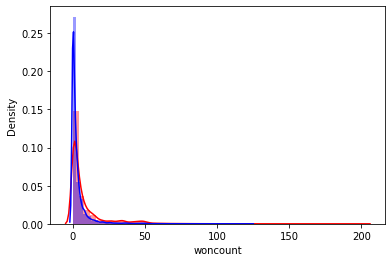

In [51]:
plot_dist('woncount')

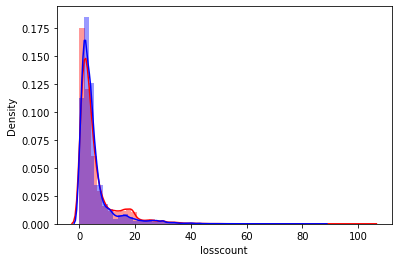

In [52]:
plot_dist('losscount')

# Seems like our feature engineered variables do not explain a lot about our labels but certainly they have some information to add to the context.

In [53]:
df.columns

Index(['ActivityDescription', 'label', 'preprocessed_text', 'newtokens', 'neg',
       'neu', 'pos', 'compound', 'sent_length', 'char_length', 'word_length',
       'num_unique_words', 'words_vs_unique', 'losscount',
       'normword_losswords', 'woncount', 'normword_wonwords'],
      dtype='object')

In [54]:
le = LabelEncoder()

X = df[["preprocessed_text","pos","neg","neu","sent_length","woncount","normword_wonwords","word_length"]]
y = df[['label']]
y = le.fit_transform(y)

# X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = tts(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = tts(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [56]:
numerical_col = ["pos","neg","sent_length","woncount","normword_wonwords","word_length"]

# Applying Multinomial Naive Bayes on BOW

In [57]:
X_train[numerical_col] = X_train[numerical_col].fillna(0)
X_val[numerical_col] = X_val[numerical_col].fillna(0)
X_test[numerical_col] = X_test[numerical_col].fillna(0)

In [58]:
vectorizer_essay_bow = CountVectorizer(min_df=5)

train_vectorized_bow = vectorizer_essay_bow.fit_transform(X_train['preprocessed_text'])
print(train_vectorized_bow.shape)

validation_vectorized_bow = vectorizer_essay_bow.transform(X_val['preprocessed_text'])

test_vectorized_bow = vectorizer_essay_bow.transform(X_test['preprocessed_text'])

(106210, 8465)


In [59]:
normalizer = Normalizer()

normalizer.fit(X_train[numerical_col].values.reshape(1, -1))

train_normalized_numerical = normalizer.transform(X_train[numerical_col].values.reshape(1, -1))

validation_normalized_numerical = normalizer.transform(X_val[numerical_col].values.reshape(1, -1))

test_df_normalized_numerical = normalizer.transform(X_test[numerical_col].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_numerical = train_normalized_numerical.reshape(-1, 1)
print(train_normalized_numerical.shape)

validation_normalized_numerical = validation_normalized_numerical.reshape(-1, 1)
print(validation_normalized_numerical.shape)

test_df_normalized_numerical = test_df_normalized_numerical.reshape(-1, 1)
print(test_df_normalized_numerical.shape)

(743470, 1)
(148694, 1)
(99134, 1)


In [91]:
X_train_hstacked_all_bow_features_vectorized = hstack((train_vectorized_bow,X_train[numerical_col]))

X_val_hstacked_all_bow_features_vectorized = hstack((validation_vectorized_bow,X_val[numerical_col]))

X_test_hstacked_all_bow_features_vectorized = hstack((test_vectorized_bow,X_test[numerical_col]))

In [61]:
multinomial_nb_bow = MultinomialNB(class_prior=[0.5, 0.5], fit_prior=False)

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

clf = GridSearchCV(multinomial_nb_bow, parameters, cv=10, scoring='roc_auc', verbose=1, return_train_score=True)

clf.fit(X_train_hstacked_all_bow_features_vectorized, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5],
                                     fit_prior=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                                   1000, 2500, 5000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [62]:
# cv_results_dict
train_auc_bow = clf.cv_results_['mean_train_score']
train_auc_std_bow = clf.cv_results_['std_train_score']

cv_auc_bow = clf.cv_results_['mean_test_score']
cv_auc_std_bow = clf.cv_results_['std_test_score']

best_alpha_1_bow = clf.best_params_['alpha']
best_score_1_bow = clf.best_score_

print('Best Alpha BOW: ', best_alpha_1_bow )
print('Best Score BOW : ', best_score_1_bow)

Best Alpha BOW:  1e-05
Best Score BOW :  0.8050728904690534


In [63]:
naive_bayes_results_for_bow_with_best_alpha = MultinomialNB(alpha = best_alpha_1_bow, class_prior=[0.5, 0.5], fit_prior=False )

naive_bayes_results_for_bow_with_best_alpha.fit(X_train_hstacked_all_bow_features_vectorized, y_train)

y_predicted_for_bow_with_best_alpha_train = naive_bayes_results_for_bow_with_best_alpha.predict_proba(X_train_hstacked_all_bow_features_vectorized)[:, 1]

y_predicted_for_bow_with_best_alpha_validation = naive_bayes_results_for_bow_with_best_alpha.predict_proba(X_val_hstacked_all_bow_features_vectorized)[:, 1]


fpr_train_bow:  [0.         0.01718282 0.01723295 ... 0.99987467 0.9999248  1.        ]


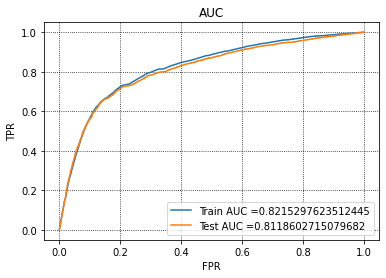

In [64]:
fpr_train_bow, tpr_train_bow, thresholds_train_bow = roc_curve(y_train, y_predicted_for_bow_with_best_alpha_train )

fpr_validation_bow, tpr_validation_bow, thresholds_validation_bow = roc_curve(y_val, y_predicted_for_bow_with_best_alpha_validation )

print('fpr_train_bow: ', fpr_train_bow)

ax = plt.subplot()

auc_bow_train = auc(fpr_train_bow, tpr_train_bow)
auc_bow_validation = auc(fpr_validation_bow, tpr_validation_bow)

ax.plot(fpr_train_bow, tpr_train_bow, label='Train AUC ='+str(auc(fpr_train_bow, tpr_train_bow)))
ax.plot(fpr_validation_bow, tpr_validation_bow, label='Test AUC ='+str(auc(fpr_validation_bow, tpr_validation_bow)))

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC')
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor('white')
plt.show()

# Naive Bayes model works fine. Now let's build Lstm model and also we can make use of numerical features by creating stacked model 

In [65]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-01-27 15:37:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-27 15:37:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-27 15:37:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [66]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(X['preprocessed_text']).batch(64)
vectorizer.adapt(text_ds)

In [67]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'call', 'followup', 'fieldsense']

In [68]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [70]:
path_to_glove_file = os.path.join("./glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [71]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

In [72]:
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11333 words (8667 misses)


In [73]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [74]:
X_train_vec = vectorizer(np.array([s for s in X_train['preprocessed_text']])).numpy()
X_cv_vec = vectorizer(np.array([s for s in X_val['preprocessed_text']])).numpy()
X_test_vec = vectorizer(np.array([s for s in X_test['preprocessed_text']])).numpy()

y_train_vec = np.array(y_train)
y_cv = np.array(y_val)
y_test = np.array(y_test)

In [75]:
from keras.callbacks import Callback

earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.005, patience=2 )

In [76]:
class F1_score(Callback):
    #callback function, that has to print the micro F1 score and AUC score after each epoch
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
    
    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        y_pred_train = np.argmax(self.model.predict(self.x),axis = 1)
        f1_score_train = f1_score(self.y, y_pred_train, average='micro')

        y_pred_val = self.model.predict(self.x_val)
        y_pred_val = np.argmax(self.model.predict (self.x_val),axis = -1)
        f1_score_val = f1_score(self.y_val, y_pred_val, average='micro')

        print('\rmicro_f1_train: %s - micro_f1_val: %s' % (str(round(f1_score_train,4)),str(round(f1_score_val,4))),end=100*' '+'\n')
        return

In [77]:
from sklearn.metrics import classification_report

In [78]:
callbacks = [F1_score(training_data=(X_train_vec, y_train_vec), validation_data=(X_cv_vec, y_cv))]
f1 = F1_score(training_data=(X_train_vec, y_train_vec),validation_data=(X_cv_vec, y_cv))

In [182]:
def plot_auc_roc(net,trainx,valx,testx,testy=y_test,trainy=y_train,valy=y_cv):
  
    y_pred_train = net.predict(trainx, batch_size=64, verbose=1)
    y_pred_bool_train = np.argmax(y_pred_train, axis=1)

    y_pred_val = net.predict(valx, batch_size=64, verbose=1)
    y_pred_bool_val = np.argmax(y_pred_val, axis=1)

    y_pred_test = net.predict(testx, batch_size=64, verbose=1)
    y_pred_bool_test = np.argmax(y_pred_test, axis=1)
    print(classification_report(y_test, y_pred_bool_test))

    fpr_train, tpr_train, thresholds_train = roc_curve(trainy, y_pred_bool_train)

    fpr_validation, tpr_validation, thresholds_validation = roc_curve(valy, y_pred_bool_val)

    fpr_test, tpr_test, thresholds_test = roc_curve(testy, y_pred_bool_test)


    # print('fpr_train: ', fpr_train)

    ax = plt.subplot()

    auc_train = auc(fpr_train, tpr_train)
    auc_validation = auc(fpr_validation, tpr_validation)
    auc_test = auc(fpr_test, tpr_test)


    ax.plot(fpr_train, tpr_train, label='Train AUC ='+str(auc(fpr_train, tpr_train)))
    ax.plot(fpr_validation, tpr_validation, label='Val AUC ='+str(auc(fpr_validation, tpr_validation)))
    ax.plot(fpr_test, tpr_test, label='Test AUC ='+str(auc(fpr_test, tpr_test)))

    plt.legend()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('AUC')
    plt.grid(b=True, which='major', color='k', linestyle=':')
    ax.set_facecolor('white')
    plt.show()

In [80]:
from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(num_tokens,embedding_dim,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False,)(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
preds = layers.Dense(df['label'].nunique(), activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         2000200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,183,754
Trainable params: 183,554
Non-trainable params: 2,000,200
_________________________________________________________________


In [81]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train_vec, y_train_vec, batch_size=128, epochs=20, validation_data=(X_cv_vec, y_cv), callbacks = [earlystop,f1])

Epoch 1/20
830/830 [==============================] - 503s 598ms/step - loss: 0.4710 - accuracy: 0.7952 - val_loss: 0.4203 - val_accuracy: 0.8192
micro_f1_train: 0.8192 - micro_f1_val: 0.8192                                                                                                    
Epoch 2/20
830/830 [==============================] - 496s 597ms/step - loss: 0.4168 - accuracy: 0.8196 - val_loss: 0.4122 - val_accuracy: 0.8193
micro_f1_train: 0.8245 - micro_f1_val: 0.8193                                                                                                    
Epoch 3/20
830/830 [==============================] - 498s 600ms/step - loss: 0.3980 - accuracy: 0.8279 - val_loss: 0.4012 - val_accuracy: 0.8262
micro_f1_train: 0.8331 - micro_f1_val: 0.8262                                                                                                    
Epoch 4/20
830/830 [==============================] - 494s 595ms/step - loss: 0.3877 - accuracy: 0.8315 - val_loss: 0.3962 -

KeyboardInterrupt: ignored

222/222 [==============================] - 19s 88ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     10641
           1       0.69      0.55      0.61      3521

    accuracy                           0.83     14162
   macro avg       0.78      0.73      0.75     14162
weighted avg       0.82      0.83      0.82     14162



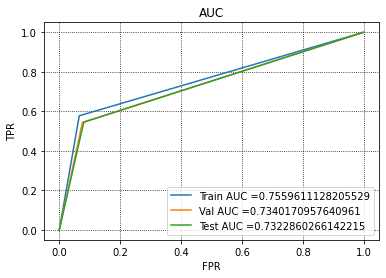

In [184]:
plot_auc_roc(model,X_train_vec,X_cv_vec,X_test_vec)

In [85]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
meta_input = tf.keras.layers.Input(shape=(7,), name='meta_input')
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(num_tokens,embedding_dim,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False,)(int_sequences_input)
num_output = tf.keras.layers.Dense(64, activation='relu')(meta_input)
num_output = tf.keras.layers.Dropout(0.1)(num_output)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
lstm_output = layers.Bidirectional(layers.LSTM(64))(x)
x = tf.keras.layers.concatenate([lstm_output, num_output])
# x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
preds = layers.Dense(df['label'].nunique(), activation="softmax")(x)
stack_model = tf.keras.Model(inputs=[int_sequences_input,meta_input],outputs=[preds])
stack_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 100)    2000200     input_5[0][0]                    
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 7)]          0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, None, 128)    84480       embedding_5[0][0]                
____________________________________________________________________________________________

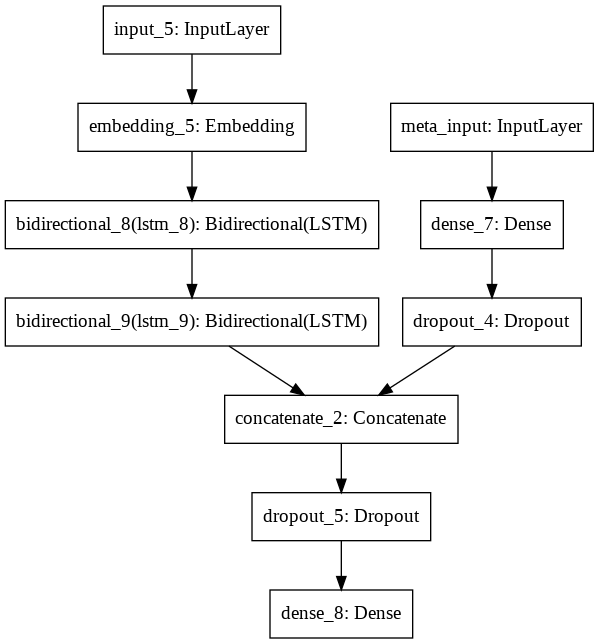

In [86]:
tf.keras.utils.plot_model(stack_model)

In [93]:
stack_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

stack_model.fit([X_train_vec,X_train[numerical_col]],y_train_vec, batch_size=64, epochs=2, callbacks = [earlystop])

Epoch 1/2
1660/1660 [==============================] - 504s 300ms/step - loss: 0.5573 - accuracy: 0.7891
Epoch 2/2
1660/1660 [==============================] - 496s 299ms/step - loss: 0.4135 - accuracy: 0.8205


222/222 [==============================] - 19s 86ms/step
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     10641
           1       0.71      0.49      0.58      3521

    accuracy                           0.82     14162
   macro avg       0.78      0.71      0.73     14162
weighted avg       0.81      0.82      0.81     14162



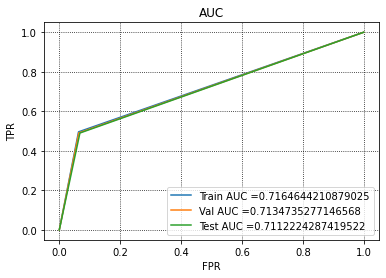

In [185]:
# def print_report(net):
#     y_pred = net.predict([X_test_vec,X_test[numerical_col]], batch_size=64, verbose=1)
#     y_pred_bool = np.argmax(y_pred, axis=1)
#     print(classification_report(y_test, y_pred_bool))
# print_report(stack_model)
plot_auc_roc(stack_model,[X_train_vec,X_train[numerical_col]],[X_cv_vec,X_val[numerical_col]],[X_test_vec,X_test[numerical_col]])

In [117]:
from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")


embedded_sequences = embedding_layer(int_sequences_input)
x1 = layers.Conv1D(128, 3, activation="relu") (embedded_sequences)
x2 = layers.Conv1D(128, 3, activation="relu") (embedded_sequences)
# x3 = layers.Conv1D(128, 3, activation="relu") (embedded_sequences)

concatted_1 = tf.keras.layers.Concatenate()([x1, x2])
x = layers.MaxPooling1D()(concatted_1)

x4 = layers.Conv1D(64, 1, activation="relu") (x)
x5 = layers.Conv1D(64, 1, activation="relu") (x)
# x6 = layers.Conv1D(64, 3, activation="relu") (x)

concatted_2 = tf.keras.layers.Concatenate()([x4, x5])
x = layers.MaxPooling1D()(concatted_2)

x = layers.Conv1D(128, 1, activation="relu")(concatted_2)
x = layers.MaxPooling1D(3)(x)

x = layers.GlobalMaxPooling1D()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10, activation="relu")(x)
preds = layers.Dense(df['label'].nunique(), activation="softmax")(x)
model1 = tf.keras.Model(int_sequences_input, preds)
model1.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    2000200     input_20[0][0]                   
__________________________________________________________________________________________________
conv1d_83 (Conv1D)              (None, None, 128)    38528       embedding[14][0]                 
__________________________________________________________________________________________________
conv1d_84 (Conv1D)              (None, None, 128)    38528       embedding[14][0]                 
___________________________________________________________________________________________

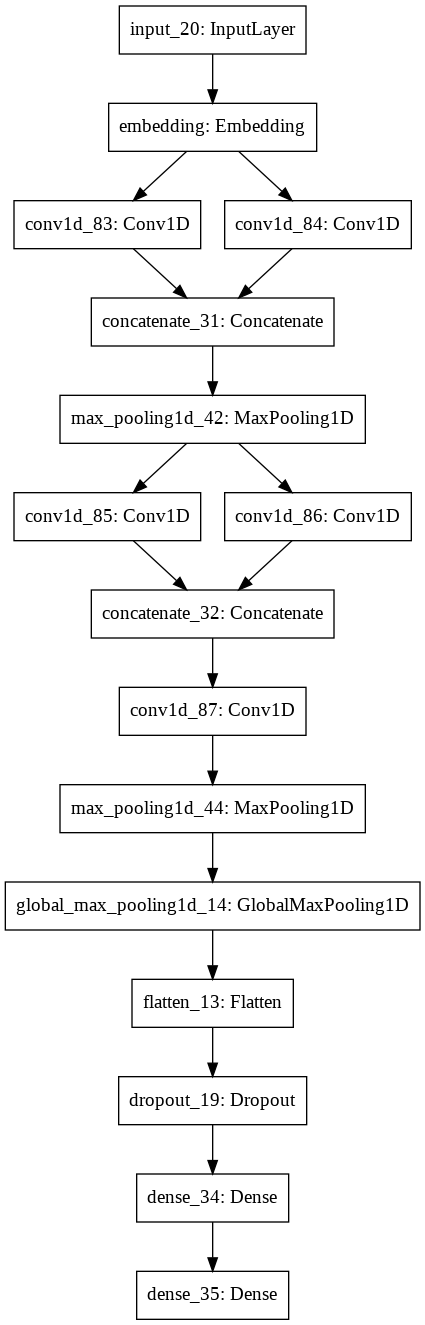

In [118]:
tf.keras.utils.plot_model(model1)

In [120]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model1.fit(X_train_vec, y_train, batch_size=128, epochs=5, validation_data=(X_cv_vec, y_cv), callbacks = [earlystop,f1])

Epoch 1/5
830/830 [==============================] - 155s 186ms/step - loss: 0.4595 - acc: 0.7997 - val_loss: 0.4205 - val_acc: 0.8188
micro_f1_train: 0.8195 - micro_f1_val: 0.8188                                                                                                    
Epoch 2/5
830/830 [==============================] - 153s 184ms/step - loss: 0.4200 - acc: 0.8178 - val_loss: 0.4114 - val_acc: 0.8201
micro_f1_train: 0.8295 - micro_f1_val: 0.8201                                                                                                    
Epoch 3/5
830/830 [==============================] - 153s 184ms/step - loss: 0.4053 - acc: 0.8217 - val_loss: 0.4084 - val_acc: 0.8223
micro_f1_train: 0.8324 - micro_f1_val: 0.8223                                                                                                    
Epoch 4/5
830/830 [==============================] - 153s 184ms/step - loss: 0.3902 - acc: 0.8315 - val_loss: 0.4048 - val_acc: 0.8237
micro_f1_train: 0.8428

222/222 [==============================] - 7s 32ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     10641
           1       0.66      0.56      0.61      3521

    accuracy                           0.82     14162
   macro avg       0.76      0.73      0.75     14162
weighted avg       0.81      0.82      0.81     14162



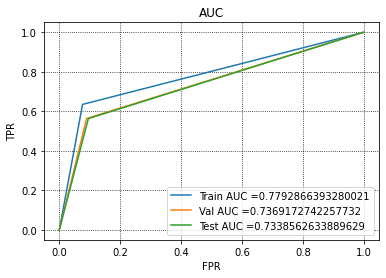

In [186]:
plot_auc_roc(model1,X_train_vec,X_cv_vec,X_test_vec)

# Bert Model

In [125]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from official.nlp.bert import tokenization

In [1]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [122]:
!pip install tensorflow_text

     |████████████████████████████████| 3.4MB 8.7MB/s 


In [ ]:
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)
encoder_inputs = preprocessing_layer(X['preprocessed_text'])

In [129]:
bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True)

# Encoding the text

In [130]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [148]:
def bert_encoder(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []
    all_type_ids = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        input_ids = tokenizer.convert_tokens_to_ids(input_sequence)
        input_ids = input_ids + ([0] * pad_len)
        attention_mask = [1] * len(input_ids)
        attention_mask = attention_mask + ([0] * pad_len)
        token_type_ids = [0] * max_len
        
        all_tokens.append(input_ids)
        all_masks.append(attention_mask)
        all_type_ids.append(token_type_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_type_ids)

In [149]:
max_len = 100

train_input = bert_encoder(X_train['preprocessed_text'].values, tokenizer, max_len=max_len)
val_input = bert_encoder(X_val['preprocessed_text'].values, tokenizer, max_len=max_len)
test_input = bert_encoder(X_test['preprocessed_text'].values, tokenizer, max_len=max_len)

# Building the model

In [165]:
# input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
# input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
# type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="type_ids")
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
#bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
# pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, type_ids])
clf_output = outputs['sequence_output'][:, 0, :]
# clf_output = sequence_output[:, 0, :]

x = tf.keras.layers.Dense(64, activation='relu')(clf_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(2, activation='softmax')(x)
Bertmodel = tf.keras.models.Model(inputs=text_input, outputs=out)    

In [166]:
Bertmodel.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
___________________________________________________________________________________________

In [ ]:
callbacks = [F1_score(training_data=(X_train_vec, y_train_vec), validation_data=(X_cv_vec, y_cv))]
f1 = F1_score(training_data=(X_train_vec, y_train_vec),validation_data=(X_cv_vec, y_cv))

In [ ]:

# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# meta_input = tf.keras.layers.Input(shape=(7,), name='meta_input')
# num_output = tf.keras.layers.Dense(128, activation='relu')(meta_input)
# num_output = tf.keras.layers.Dropout(0.1)(num_output)
# # preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
# # encoder_inputs = preprocessing_layer(text_input)
# encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
# outputs = encoder(text_input)
# net = outputs['pooled_output']
# x = tf.keras.layers.concatenate([net, num_output])
# x = tf.keras.layers.Dense(10, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(x)
# stack_model = tf.keras.Model(inputs=[text_input,meta_input],outputs=[x])

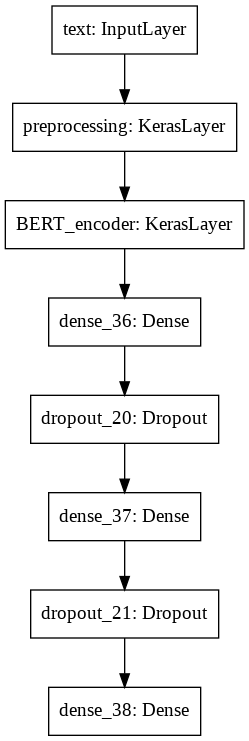

In [154]:
tf.keras.utils.plot_model(Bertmodel)

In [124]:
!pip install tf-models-official

     |████████████████████████████████| 1.1MB 8.5MB/s 
     |████████████████████████████████| 37.6MB 1.4MB/s 
     |████████████████████████████████| 174kB 56.2MB/s 
     |████████████████████████████████| 1.2MB 48.7MB/s 
     |████████████████████████████████| 645kB 38.9MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 358kB 38.5MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=26a8fcc1f2e7a624bf0b0aeafb3310ffd5e2061c7c0e0c48acf07fbdf2397445
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=6fad54f8b6b34bdacd1c079881296beb86be3f0f9c1b36e048ccae3ea5825299
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built seqeval py

In [167]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(text_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [168]:
Bertmodel.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Bertmodel.fit(X_train['preprocessed_text'],y_train, validation_data = (X_val['preprocessed_text'],y_cv),batch_size=64, epochs=2, callbacks = [earlystop])

Epoch 1/2
1660/1660 [==============================] - 1849s 1s/step - loss: 0.7661 - accuracy: 0.6310 - val_loss: 0.4299 - val_accuracy: 0.8119
Epoch 2/2
1660/1660 [==============================] - 1840s 1s/step - loss: 0.4518 - accuracy: 0.8056 - val_loss: 0.4134 - val_accuracy: 0.8195


222/222 [==============================] - 62s 281ms/step
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     10641
           1       0.71      0.46      0.56      3521

    accuracy                           0.82     14162
   macro avg       0.77      0.70      0.72     14162
weighted avg       0.81      0.82      0.80     14162



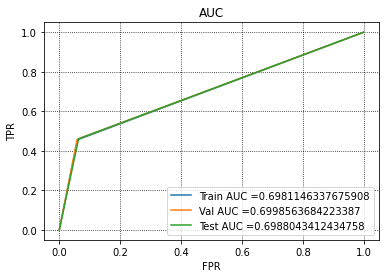

In [188]:
plot_auc_roc(Bertmodel,X_train['preprocessed_text'],X_val['preprocessed_text'],X_test['preprocessed_text'])